In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Artic V4 coverage data

### Coverage data from Josh Quick used to create an amplicon abundance distribution for ARTIC V4. 

The method is to look at the coverage data and for each amplicon, take the mean coverage value starting from the right edge of the preceding amplicon's right primer position, and ending at the left edge of the following amplicon's left primer position. 

At amplicon 1, take the mean coverage from the start of the left primer to the start of amplicon 2 left primer. 
At amplicon 98 (last amplicon) take the mean coverage from the end of right primer 97 to the right end of amplicon 98 right primer. 

This is the black line in the graph, and also shows the 'sum' inbetween, which in theory should be the sum of the coverages on either side. 

In [48]:
df = pd.read_csv("/home/will/Downloads/PTC_10-3.sorted.bam.cov", sep="\t", header=None, names=["genome", "position", "coverage"])
artic = pd.read_csv(
    "/home/will/Desktop/projects/embl/sars-cov-2-metagenomics-simulator/data/protocols/artic_v4_SARS-CoV-2.primer.bed", 
    sep="\t", header=None, names=["genome","start","end","name"], usecols=[i for i in range(4)])
df.head()

,genome,position,coverage
0,MN908947.3,1,1
1,MN908947.3,2,1
2,MN908947.3,3,1
3,MN908947.3,4,1
4,MN908947.3,5,1


In [49]:
COVERAGE_VECTOR = np.array(df["coverage"])

In [50]:
def add_cols(df):
    # split the column "name" to extract useful data
    df["amplicon_number"] = df["name"].apply(lambda x: int(x.split("_")[1]))
    df["handedness"] = df["name"].apply(lambda x: x.split("_")[2])
    df["is_alt"] = df["name"].apply(lambda x: len(x.split("_")) > 3)
    df = pd.merge(
        df.loc[df["handedness"] == "LEFT"], 
        df.loc[df["handedness"] == "RIGHT"], 
        on=["amplicon_number", "is_alt"]
    )
    

    # rename the columns to more understandable names
    
    df = pd.DataFrame(
        df[["genome_x", "amplicon_number", "is_alt", "name_x",
        "start_x", "end_y"]]
    )

    df = df.rename(columns={
        "name_x":"name",
        "genome_x":"ref", 
        "start_x":"left_start", 
        "end_y":"right_end"})
    
    return df
artic = add_cols(artic)


In [51]:
artic["next_start"] = artic["left_start"].shift(-1)
artic["next_start"] = artic["next_start"].fillna(artic["right_end"])
artic["prev_end"] = artic["right_end"].shift(1)
artic["prev_end"] = artic["prev_end"].fillna(artic["left_start"])
artic["mean_cov"] = artic.apply(lambda x: np.mean(COVERAGE_VECTOR[int(x['prev_end']):int(x['next_start'])]), axis=1)
artic.head()

,ref,amplicon_number,is_alt,name,left_start,right_end,next_start,prev_end,mean_cov
0,MN908947.3,1,False,SARS-CoV-2_1_LEFT,25,431,324.0,25.0,137.909699
1,MN908947.3,2,False,SARS-CoV-2_2_LEFT,324,727,644.0,431.0,832.873239
2,MN908947.3,3,False,SARS-CoV-2_3_LEFT,644,1044,944.0,727.0,1111.594470
3,MN908947.3,4,False,SARS-CoV-2_4_LEFT,944,1362,1245.0,1044.0,1088.597015
4,MN908947.3,5,False,SARS-CoV-2_5_LEFT,1245,1650,1540.0,1362.0,378.382022


In [52]:
mydata = []
row = 0
for i in df['position']:
    if i == artic.loc[row, 'right_end']:
        row += 1
        if row == 99:
            row = 98
            
    if artic.loc[row, 'prev_end'] < i and artic.loc[row, 'next_start'] > i:
        mydata.append(artic.loc[row, 'mean_cov'])
    
    elif artic.loc[row, 'prev_end'] < i and artic.loc[row, 'next_start'] <= i:
        mydata.append(artic.loc[row, 'mean_cov'] + artic.loc[min(row + 1, 98), 'mean_cov'])
    
    elif artic.loc[row, 'prev_end'] >= i and artic.loc[row, 'next_start'] > i:
        mydata.append(artic.loc[max(row - 1, 0), 'mean_cov'] + artic.loc[row, 'mean_cov'])        
    
    else:
        mydata.append(0)
        

Text(0, 0.5, 'coverage')

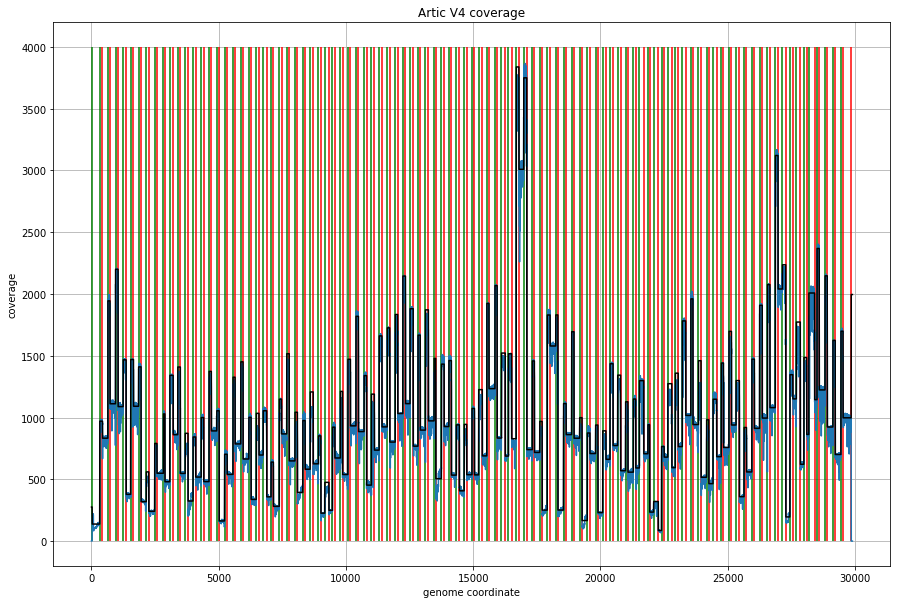

In [53]:
plt.figure(figsize=(15, 10))#figsize=(60, 40))
plt.subplot(111)
plt.plot(df['coverage'])
plt.vlines([artic['left_start']], ymin=0, ymax=4000, color="g")
plt.vlines([artic['right_end']], ymin=0, ymax=4000, color="r")
plt.plot(mydata, color="black")
#n = 0
#plt.xlim(n+0, n+3000)
plt.grid()
plt.title("Artic V4 coverage")
plt.xlabel("genome coordinate")
plt.ylabel("coverage")
#plt.savefig("artic_v4_coverage.pdf", format="pdf", dpi=4096)

The graph above shows:

- green vertical lines are left primer start positions. 
- red vertical lines are right primer end positions. 
- blue graph is the raw coverage data. 
- black line is calculated as the mean of the coverage values between two amplicons, otherwise it is the sum (where amplicons overlap). 

In [54]:
artic['hyperparameter'] = artic['mean_cov']/sum(artic['mean_cov'])
data_to_save = pd.DataFrame(artic[['amplicon_number','hyperparameter']])

In [55]:
#data_to_save.to_csv("../example/artic_v4_amplicon_hyperparameter.tsv", sep="\t", index=False)